# Data Cleaning and Preparation for Amazon Fashion Dataset

### Overview
This notebook documents the process of downloading, cleaning, analyzing, and preparing the Amazon Fashion dataset for further use, such as building a vector database. The dataset contains product information, including titles, ratings, features, descriptions, prices, and images. The goal is to optimize the dataset by removing unnecessary columns, handling missing data, and reducing its size to meet GitHub's 100MB file size limit.

### Steps and Workflow
- **Initial Setup**:
    - Imported necessary libraries (`pandas`, `matplotlib`, etc.).
    - Configured pandas options for better display of data.
- **Data Downloading and Loading**:
    - Downloaded the dataset from a specified URL and saved it locally as a compressed JSONL file.
    - Loaded the dataset into a pandas DataFrame.
- **Exploratory Data Analysis (EDA)**:
    - Inspected the structure and content of the dataset using `.head()`, `.columns`, and `.iloc`.
    - Analyzed the distribution of key columns like `main_category`, `average_rating`, and `rating_number`.
- **Data Cleaning**:
    - Dropped irrelevant or empty columns such as `bought_together`, `videos`, `main_category`, and `categories`.
    - Extracted and retained only the `MAIN` `HIGH_RES` image URLs.
    - Concatenated multi-part descriptions into a single string.
    - Removed unnecessary prefixes from image URLs to reduce file size.
- **Data Optimization**:
    - Converted data types (e.g., `float32`, `int32`, `category`) to save memory.
    - Randomly dropped 5% of the data to reduce the dataset size.
- **Data Export**:
    - Saved the cleaned and optimized dataset as a compressed CSV file.

### Main Findings
- The dataset contained several columns with missing or irrelevant data:
    - `price` was missing for the majority of products.
    - `bought_together` and `categories` were fully null and dropped.
    - `main_category` had no variation and was removed.
- The `features` and `details` columns provided valuable information about the products.
- All non-null image URLs followed a consistent format, allowing for efficient processing.
- Multi-part descriptions were concatenated to improve usability.

### Results
- The cleaned dataset contains 784,803 rows and 9 columns.
- The dataset size was reduced to below 100MB by:
    - Dropping unnecessary columns.
    - Optimizing data types.
    - Removing 5% of the data randomly.
- The final dataset was saved as a compressed CSV file (`products.csv`) for further use.

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
import requests

In [2]:
# This function will help us later when handling columns of dtype list
def flatten_and_count(df, column):
    """
    Flatten a column of lists and count occurrences of each unique item.
    """
    # Flatten all category lists (filtering out non-lists or NaNs)
    flattened = [
        category for row in df[column] if isinstance(row, list) for category in row
    ]

    # Count occurrences
    category_counts = Counter(flattened)

    # Convert to DataFrame for better readability or export
    category_df = pd.DataFrame.from_dict(
        category_counts, orient="index", columns=["count"]
    ).sort_values(by="count", ascending=False)

    return category_df

In [3]:
# Define the URL of the dataset and the local path where it will be saved
url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Amazon_Fashion.jsonl.gz"
output_path = "./raw/meta_Amazon_Fashion.jsonl.gz"

# Check if the file already exists at the specified path
file_exists = os.path.exists(output_path)

# Print a message based on whether the file exists or not
if file_exists:
    print(f"The file already exists at {output_path}")
else:
    print(f"No file found at {output_path}")

The file already exists at ./raw/meta_Amazon_Fashion.jsonl.gz


In [4]:
# Check if the file already exists
if not file_exists:
    # If the file does not exist, download it from the specified URL
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # Write the file in chunks to avoid memory issues with large files
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"File downloaded and saved to {output_path}")
    else:
        # Print an error message if the download fails
        print(f"Failed to download file. Status code: {response.status_code}")
else:
    # If the file already exists, print a message
    print(f"The file already exists at {output_path}. Skipped download.")

The file already exists at ./raw/meta_Amazon_Fashion.jsonl.gz. Skipped download.


In [5]:
# Read the downloaded file into a pandas DataFrame
df = pd.read_json(output_path, lines=True, compression="gzip")

In [6]:
# Check the first few rows of the DataFrame
df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,AMAZON FASHION,YUEDGE 5 Pairs Men's Moisture Control Cushione...,4.6,16,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],GiveGift,[],{'Package Dimensions': '10.31 x 8.5 x 1.73 inc...,B08BHN9PK5,NaN
1,AMAZON FASHION,DouBCQ Women's Palazzo Lounge Wide Leg Casual ...,4.1,7,"[Drawstring closure, Machine Wash]",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],DouBCQ,[],{'Package Dimensions': '15 x 10.2 x 0.4 inches...,B08R39MRDW,NaN
2,AMAZON FASHION,Pastel by Vivienne Honey Vanilla Girls' Trapez...,4.3,11,"[Zipper closure, Hand Wash Only]",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Pastel by Vivienne,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",B077KJHCJ4,NaN
3,AMAZON FASHION,Mento Streamtail,2.0,1,"[Thermoplastic Rubber sole, High Density Premi...",[Slip on the Women's Mento and you're ready to...,29.81,[{'thumb': 'https://m.media-amazon.com/images/...,[],Guy Harvey,[],{'Package Dimensions': '11.22 x 4.72 x 4.33 in...,B0811M2JG9,NaN
4,AMAZON FASHION,RONNOX Women's 3-Pairs Bright Colored Calf Com...,4.3,3032,"[Pull On closure, Size Guide: ""S"" fits calf 10...",[Ronnox Calf Sleeves - Allowing Your Body to P...,17.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'HONEST Review: RONNOX Women's 3-Pa...,RONNOX,[],"{'Is Discontinued By Manufacturer': 'No', 'Pac...",B07SB2892S,NaN


In [7]:
# Display the columns of the DataFrame to understand its structure
df.columns

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together'],
      dtype='object')

In [8]:
# Deep dive into a random row
df.iloc[3].to_dict()

{'main_category': 'AMAZON FASHION',
 'title': 'Mento Streamtail',
 'average_rating': 2.0,
 'rating_number': 1,
 'features': ['Thermoplastic Rubber sole',
  'High Density Premium Thickness Comfort Foam Footbed',
  'Full Color Original Guy Harvey Artwork On Wavy Outsole',
  'Soft Canvas Strap Lining with Embroidered Logo',
  'Screen Printed Logo on Footbed',
  'Lightweight Non-Marking EVA Outsole with Flex Grooves'],
 'description': ["Slip on the Women's Mento and you're ready to hit the beach. This thong sandal features canvas straps with a soft lining, a high density premium thickness comfort foam footbed and a lightweight non-marking EVA outsole with flex grooves. A full color digital print of Guy Harvey's artwork is featured on the wavy outsole."],
 'price': 29.81,
 'images': [{'thumb': 'https://m.media-amazon.com/images/I/31P-uHUUIXL._AC_US40_.jpg',
   'large': 'https://m.media-amazon.com/images/I/31P-uHUUIXL._AC_.jpg',
   'variant': 'MAIN',
   'hi_res': 'https://m.media-amazon.com/

We dont need all images for our prototype so let's pick up 1 image only - which is the `MAIN` `HIGH_RES` version

In [9]:
df["main_hi_res_image"] = df["images"].apply(
    lambda images: (
        next(
            (
                img.get("hi_res")
                for img in images
                if img.get("variant", "").lower() == "main"
            ),
            None,
        )
        if isinstance(images, list)
        else None
    )
)
df = df.drop("images", axis=1)

In [10]:
# Create and display a dataframe that summarizes the products
pd.DataFrame(
    {
        "Column Name": df.columns,
        "Data Type": df.dtypes.values,
        "Non-Null Count": df.notnull().sum().values,
        "Null Count": df.isnull().sum().values,
    }
)

,Column Name,Data Type,Non-Null Count,Null Count
0,main_category,object,826108,0
1,title,object,826108,0
2,average_rating,float64,826108,0
3,rating_number,int64,826108,0
4,features,object,826108,0
5,description,object,826108,0
6,price,float64,50249,775859
7,videos,object,826108,0
8,store,object,799270,26838
9,categories,object,826108,0


- We see that `price` is missing for majority of products.
- `bought_together` is fully null and can be dropped.


In [11]:
df = df.drop("bought_together", axis=1)

In [12]:
# Let's also remove videos as it won't be needed in our prototype
df = df.drop("videos", axis=1)

In [13]:
# Check main category distribution
df["main_category"].value_counts(dropna=False)

main_category
AMAZON FASHION    826108
Name: count, dtype: int64

In [14]:
# There is no variation so we can safely drop this columns
df = df.drop("main_category", axis=1)

In [15]:
# Check the distribution of the categories
flatten_and_count(df, "categories")

,count


In [16]:
# Categories are fully empty so it can be dropped
df = df.drop("categories", axis=1)

In [17]:
# Do the same for features column
flatten_and_count(df, "features")

,count
Pull On closure,103164
Hand Wash Only,82942
Machine Wash,70510
Button closure,32517
Zipper closure,31238
...,...
"Large Silver Storage Bag: you will get 1 large zipper blue storage bag that measures 24 x 30 inches, which can hold many pieces of silverware, you do not need to spend time and energy in buying multiple smaller storage bags",1
"Keep Silverware and Jewelry Shiny: the anti tarnish silver storage bags can keep the jewelry, silverware, and others in bright and shiny condition, providing you with a long time of application and comfortable use experience",1
"Zipper and Color Design: zipper silver keeper bag allows you to easily put and take out silver containers, which is very convenient and safe to use; Blue is a very classic color, and the use of silverware gives a sense of nobility",1
"Soft and Comfortable Material: the anti tarnish bag is mainly made of double flannelette fabric, which is soft, comfortable and will not rub the silverware surface; Strong shading performance is hard to expose to sunlight; You can use it for a long time",1


There are 211,142 unique categories with most common ones as Pull On closure, Hand Wash Only, Machine Wash, Button closure, Zipper closure.

In [18]:
# Lets look into details columns
df["details_keys"] = df["details"].apply(lambda details: list(details.keys()) if isinstance(details, dict) else {})
flatten_and_count(df, "details_keys")

,count
Date First Available,797051
Package Dimensions,528478
Item model number,371915
Is Discontinued By Manufacturer,295500
Product Dimensions,160469
...,...
Model Info,1
Safety Rating,1
Microphone Form Factor,1
Vehicle Service Type Passenger Car,1


We see there 544 types of details such as model number, whether its discontinued or not. This is valuable information so let's keep it.

In [19]:
df = df.drop("details_keys", axis=1)

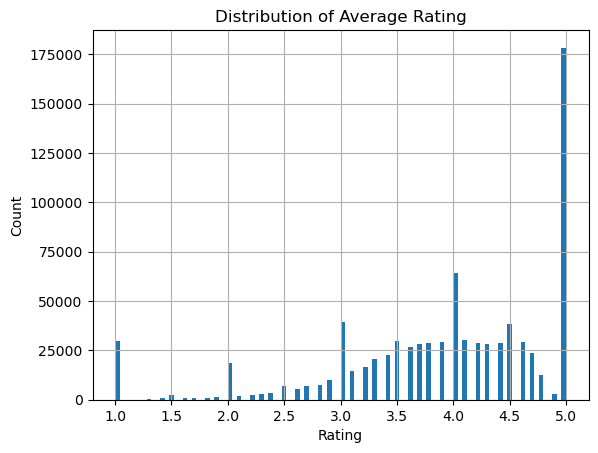

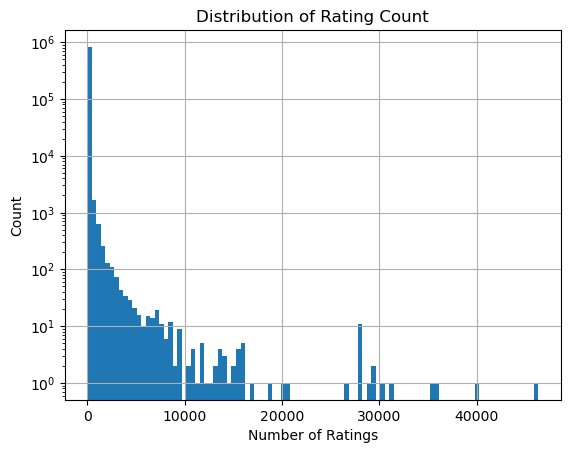

In [20]:
# Lets check how ratings are distributed

# Histogram for average rating
df["average_rating"].dropna().hist(bins=100)
plt.title("Distribution of Average Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Histogram for number of ratings
df["rating_number"].dropna().hist(bins=100)
plt.title("Distribution of Rating Count")
plt.xlabel("Number of Ratings")
plt.ylabel("Count")
plt.yscale("log")  # optional: log scale for better visibility
plt.show()

In [21]:
# Now let's check description which is suprisingly a list field (Expected a string)
df["description_length"] = df["description"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

df["description_length"].value_counts().sort_index()

description_length
0      766819
1       48146
2        1705
3         757
4        1000
5         760
6         922
7         617
8         669
9         619
10        533
11        471
12        514
13        342
14        268
15        297
16        227
17        178
18        144
19        109
20        154
21        102
22        116
23         61
24         79
25         88
26         56
27         29
28         53
29         31
30         32
31         25
32         29
33         13
34         23
35          9
36         12
37         11
38         20
39          5
40         12
41          3
42          6
43          1
44          4
45          5
46          8
47          3
48          2
50          3
52          2
54          5
55          2
57          1
58          1
65          1
71          1
75          1
83          1
101         1
Name: count, dtype: int64

In [22]:
# Let's check cases where there are multiple descriptions
df[df["description_length"] > 3].head()["description"].values

array([list(['Brand:MSGUIDE', 'Size:', '28.3"(L) x 25.6"(W)', 'Gender:', 'Unisex', 'Aadjustable:', 'Adjustable Extra Long Ties, suitable for most men and women', 'Waterproof:', 'This apron is made of Oxford cloth, resistant to dirt and abrasion, and can well protect your clothes from oil.', 'Multi-purpose:', 'ideal for kitchen,Cooking,Baking,Barbeque,camping, parties, picnics,garden and so onThe stylish adjustable apron is suitable for most male and female chef artist waiter butchers. This unique apron is perfect for any festive occasions such as cooking, baking, gardening, DIY, party, barbecue, cleaning, painting, etc. If you are a housewife, dining at home, a coffee shop clerk, a painter or some parts that require safety protection, the bib apron to keep your clothes clean.', 'Note:', "Pictures may slightly vary from actual item due to lighting and monitor. So it's normal to have a little bit of chromatic aberration."]),
       list(['Simple fashion clear bracelets, many kinds of sto

We can see that these are just parts of an overall description. Let's concatenate them with space in between list elements

In [23]:
df["description"] = df["description"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else x
)
df = df.drop("description_length", axis=1)

In [24]:
# Lets also remove parent_asin as people usually don't search using ASIN numbers
# This is done in order to reduce the size of the dataset to below 100MB which is the limit by GitHub
df = df.drop("parent_asin", axis=1)

In [25]:
# Set pandas options to display full text in each column
pd.set_option("display.max_colwidth", None)

# Display the first 20 rows of the "main_hi_res_image" column
df["main_hi_res_image"].dropna().head(20)

0     https://m.media-amazon.com/images/I/81XlFXImFrS._AC_UL1500_.jpg
1     https://m.media-amazon.com/images/I/91Z4G2jlFeL._AC_UL1500_.jpg
2     https://m.media-amazon.com/images/I/612-CtsBAvL._AC_UL1500_.jpg
3     https://m.media-amazon.com/images/I/61qmATFO2FL._AC_UL1500_.jpg
4     https://m.media-amazon.com/images/I/91ub366PdKL._AC_UL1500_.jpg
6     https://m.media-amazon.com/images/I/61PXLV7A9DL._AC_UL1500_.jpg
7     https://m.media-amazon.com/images/I/51wifGtXJmL._AC_UL1001_.jpg
8     https://m.media-amazon.com/images/I/61Rz6OajP5L._AC_UL1004_.jpg
9     https://m.media-amazon.com/images/I/71ZtYP0GfdL._AC_UL1500_.jpg
10    https://m.media-amazon.com/images/I/71TvGyW0afL._AC_UL1500_.jpg
11    https://m.media-amazon.com/images/I/71qnfc60uEL._AC_UL1300_.jpg
12    https://m.media-amazon.com/images/I/518JI5jtL8L._AC_UL1000_.jpg
13    https://m.media-amazon.com/images/I/61FYGwTQmzL._AC_UL1200_.jpg
14    https://m.media-amazon.com/images/I/71AqYf+W5FL._AC_UL1500_.jpg
15    https://m.medi

In [26]:
# We observe that URL always starts with "https://m.media-amazon.com/images/I/"
# (Does not necessarily end with ".jpg" as there are .png examples)
# Lets remove this prefix and add it later when we need to display the image
# This will help us reduce the size of the dataset

# Before that, let's validate that all URLs indeed start with this prefix
# Define the expected format
expected_format = r"^https://m\.media-amazon\.com/images/I/.*$"

# Count rows matching the format
matching_rows = df["main_hi_res_image"].str.match(expected_format, na=False).sum()

# Count rows not matching the format
non_matching_rows = df["main_hi_res_image"].notna().sum() - matching_rows

matching_rows, non_matching_rows

(777744, 0)

Indeed, all non-null image links start with the "https://m.media-amazon.com/images/I/" and end with ".jpg". Let's remove these strings from the column

In [27]:
# Remove only the prefix from the URLs
df["main_hi_res_image"] = df["main_hi_res_image"].str.replace(
    r"^https://m\.media-amazon\.com/images/I/", "", regex=True
)

## Optimize df and save

In [28]:
# Optimize data types
df["average_rating"] = df["average_rating"].astype("float32")
df["rating_number"] = df["rating_number"].astype("int32")
df["price"] = df["price"].astype("float32")
df["store"] = df["store"].astype("category")

In [29]:
# At this stage, we can save the DataFrame to a CSV file in compressed format
# However, file size would still be above 100 MB which is the permitted size by GitHub
# Lets remove 5% of data randomly and save the remaining data in order to reduce the size

# Save the DataFrame with compression
df_sample = df.sample(frac=0.95, random_state=42)  # Drop 5% of rows randomly
df_sample.to_csv("./products.csv", index=False, compression="zip")

In [30]:
# Check whether the size of saved table is below 100MB
file_size = os.path.getsize("./products.csv")
print(f"Size of './products.csv': {file_size / (1024 * 1024):.2f} MB")

Size of './products.csv': 96.65 MB


- With removing unnecessary rows, optimizing dtypes, and dropping 5% of data, we were able to save the data with a size below 100MB
- The resulting data file can be used to build the Vector Database